In [24]:
import torch
print(torch.__version__)

2.5.1+cu121


In [45]:
# Feature Extractor
from pytorchvideo.models.hub import x3d_s
import torch
from torch import nn

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained x3d_s model
model = x3d_s(pretrained=True).to(device)

# Modify block 5 to include explicit global average pooling
class FeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.backbone = torch.nn.Sequential(*model.blocks[:-1])  # Blocks 0-4
        self.final_block = model.blocks[5].pool  # Block 5 (unchanged)
        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))  # Define global average pooling layer

    def forward(self, x):
        # print(f"Input shape: {x.shape}")  # Debug input shape
        x = self.backbone(x)  # Pass through blocks 0-4
        # print(f"After backbone shape: {x.shape}")  # Debug backbone output shape
        x=self.final_block(x)
        # print(f"After final_block shape: {x.shape}")  # Debug backbone output shape
        x = self.pool(x)  # Pass through block 5 pooling
        # print(f"After pooling shape: {x.shape}")  # Debug pooling output shape

        x = torch.mean(x, dim=[-3, -2, -1], keepdim=True)  # Apply global average pooling
        # print(f"After global average pooling shape: {x.shape}")  # Debug GAP output shape

        return x

# Initialize the feature extractor
feature_extractor = FeatureExtractor(model)

# Define feature extraction function
def extract_features(segments, device, model=feature_extractor):
    """
    Extract features from video segments using the modified model.

    Args:
        model (torch.nn.Module): Pretrained and modified model.
        segments (list): List of video segments (tensors).
        device (torch.device): Device for computation.

    Returns:
        list: List of feature tensors.
    """
    features = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment = segment.unsqueeze(0).to(device)  # Add batch dimension and move to device
            feature = model(segment)  # Extract features
            features.append(feature.squeeze(0).cpu())  # Remove batch dimension and move to CPU
    return features

if __name__=='__main__':
    # Test with a dummy input
    dummy_input = torch.randn(4, 3, 16, 240, 320).to(device)  # Example input: (batch_size, channels, frames, height, width)
    output = feature_extractor(dummy_input)
    print(f"Final feature shape: {output.shape}")  # Expected output: [1, 2048, 1, 1, 1]


Final feature shape: torch.Size([4, 2048, 1, 1, 1])


In [46]:
# extract segments
import cv2
def extract_segments_from_video(video_path, segment_size=16, target_shape=(240, 320), frame_skip=10):
    """
    Extracts video segments with frame skipping and efficient memory usage.

    Args:
        video_path (str): Path to the video file.
        segment_size (int): Number of frames per segment.
        target_shape (tuple): Target resolution (height, width) for frames.
        frame_skip (int): Number of frames to skip during extraction.

    Returns:
        list: List of segments, where each segment is a tensor of shape [C, T, H, W].
    """
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Unable to open video file: {video_path}")
        
        segments = []
        frames = []
        frame_count = 0

        while True:
            success, frame = cap.read()
            if not success:
                break

            # Skip frames based on frame_skip value
            if frame_count % frame_skip != 0:
                frame_count += 1
                continue

            # Resize frame and convert to tensor
            frame = cv2.resize(frame, target_shape)
            frame_tensor = torch.tensor(frame).permute(2, 0, 1).float() / 255.0  # Normalize to [0, 1]
            frames.append(frame_tensor)

            # Create a segment if enough frames are collected
            if len(frames) == segment_size:
                segments.append(torch.stack(frames, dim=1))  # Stack frames [C, T, H, W]
                frames = []

            frame_count += 1

        # Handle leftover frames (pad to segment size)
        if frames:
            while len(frames) < segment_size:
                frames.append(torch.zeros_like(frames[0]))  # Pad with black frames
            segments.append(torch.stack(frames, dim=1))

        cap.release()
        return segments

    except Exception as e:
        cap.release()
        print(f"Error processing video {video_path}: {e}")
        raise e



In [93]:
# segments divided into batches
from torch.amp import autocast
import tqdm
video_path=r"E:\MIL\Dataset\Anomaly-Videos\Anomaly-Videos-Part-2\Explosion\Explosion002_x264.mp4"
segment=extract_segments_from_video(video_path,frame_skip=3)
batch_size=4
batches = [segment[i:i + batch_size] for i in range(0, len(segment), batch_size)]



In [94]:
# extract features 
from tqdm import tqdm
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
debug =True
features = []
for batch in tqdm(batches, desc="Extracting Features"):
    batch = torch.stack(batch).to(device)  # Convert batch to tensor
    print(f"Batch shape: {batch.shape}") if debug else None

    with autocast("cuda"):
        batch_features = extract_features(batch, device)  # Extract features
        print(f'batch_feature[0]:{batch_features[0].shape}')

    if isinstance(batch_features, list):
        batch_features = torch.stack(batch_features)  # Ensure tensor type
    features.append(batch_features.cpu())

Extracting Features:   0%|          | 0/21 [00:00<?, ?it/s]

Batch shape: torch.Size([4, 3, 16, 320, 240])


Extracting Features:  10%|▉         | 2/21 [00:00<00:05,  3.59it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
batch_feature[0]:torch.Size([2048, 1, 1, 1])


Extracting Features:  14%|█▍        | 3/21 [00:00<00:04,  4.16it/s]

Batch shape: torch.Size([4, 3, 16, 320, 240])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
batch_feature[0]:torch.Size([2048, 1, 1, 1])


Extracting Features:  24%|██▍       | 5/21 [00:01<00:02,  5.78it/s]

Batch shape: torch.Size([4, 3, 16, 320, 240])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])


Extracting Features:  29%|██▊       | 6/21 [00:01<00:02,  6.24it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])


Extracting Features:  38%|███▊      | 8/21 [00:01<00:01,  7.17it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])


Extracting Features:  48%|████▊     | 10/21 [00:01<00:01,  7.67it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
batch_feature[0]:torch.Size([2048, 1, 1, 1])


Extracting Features:  67%|██████▋   | 14/21 [00:02<00:00,  9.09it/s]

Batch shape: torch.Size([4, 3, 16, 320, 240])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])


Extracting Features:  76%|███████▌  | 16/21 [00:02<00:00,  9.47it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])


Extracting Features:  86%|████████▌ | 18/21 [00:02<00:00,  8.76it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])


Extracting Features:  95%|█████████▌| 20/21 [00:02<00:00,  8.29it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])


Extracting Features: 100%|██████████| 21/21 [00:02<00:00,  7.29it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])


In [95]:
features_list=features

In [115]:
video_1=r"E:\MIL\Code\debug_processed_features\Explosion002_x264_features.pt"
data=torch.load(video_1)
features=data.get("features")

C:\Users\vikra\AppData\Local\Temp\ipykernel_1520\1178720715.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data=torch.load(video_1)


In [96]:
# Combine features from all batches
import os
features = torch.cat(features_list, dim=0)
label=1
output_dir=r"E:\MIL\Code\debug_processed_features"
print(f"Combined Features Shape: {features.shape}") if debug else None

# Step 5: Save features and labels
video_name = os.path.splitext(os.path.basename(video_path))[0]
torch.save({
    "features": features,  # Tensor containing extracted features
    "label": label  # Label associated with the video
}, os.path.join(output_dir, f"{video_name}_features.pt"))

# Clear GPU memory
torch.cuda.empty_cache()
print(f"Processed video: {video_name}, Label: {label}")

Combined Features Shape: torch.Size([84, 2048, 1, 1, 1])
Processed video: Explosion002_x264, Label: 1


In [97]:
# define loss function
def combined_loss(scores, labels, lamda_sparsity=8e-5, lamda_smooth=8e-5):
    """
    Calculates the combined loss function for weakly-supervised MIL anomaly detection.

    The combined loss consists of:
    1. Binary Cross-Entropy Loss with Logits:
       - This is the classification loss that measures how well the model predicts the 
         anomaly scores for each segment. It internally applies the sigmoid function 
         to convert logits into probabilities before calculating the loss.
    
    2. Sparsity Loss:
       - This encourages sparsity in anomaly predictions by penalizing the sum of 
         predicted probabilities across all segments. It helps the model focus on 
         a small number of segments likely to contain anomalies.

    3. Smoothness Loss:
       - This penalizes abrupt changes in predictions across adjacent segments 
         to ensure temporal smoothness in the predicted anomaly scores.

    Parameters:
    - scores (torch.Tensor): Predicted logits from the model. Shape: [num_segments].
    - labels (torch.Tensor): Ground truth labels. Shape: [num_segments].
    - lamda_sparsity (float): Weight for sparsity loss. Default: 8e-5.
    - lamda_smooth (float): Weight for smoothness loss. Default: 8e-5.

    Returns:
    - torch.Tensor: The combined loss value.
    """
    # Binary Cross-Entropy Loss with Logits (handles sigmoid internally)
    ce_loss = nn.BCEWithLogitsLoss()(scores, labels)

    # Sparsity Loss: Penalizes the sum of predicted probabilities (encourages sparse anomaly detection)
    sparsity_loss = lamda_sparsity * torch.sum(torch.sigmoid(scores))

    # Smoothness Loss: Penalizes abrupt changes in adjacent segment predictions
    smoothness_loss = lamda_smooth * torch.sum((torch.sigmoid(scores[1:]) - torch.sigmoid(scores[:-1])) ** 2)

    # Combined loss
    return ce_loss + sparsity_loss + smoothness_loss

In [98]:
# define model
import torch
import torch.nn as nn
from torch.amp import GradScaler


class SequentialMILModel(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=512):
        """
        Initializes a Sequential MIL Model for anomaly detection.

        Parameters:
        - input_dim (int): Input feature dimension (default: 2048).
        - hidden_dim (int): Hidden layer dimension (default: 512).
        """
        super(SequentialMILModel, self).__init__()
        print("SequentialMILModel Initialized")  # Debug print
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_dim, 32)         # Second fully connected layer
        self.fc3 = nn.Linear(32, 1)                 # Final output layer
        self.dropout = nn.Dropout(0.6)              # Dropout with probability 0.6
        self.relu = nn.ReLU()                       # ReLU activation
        self.sigmoid = nn.Sigmoid()                 # Sigmoid activation for output

    def forward(self, x):
        """
        Forward pass for the model.

        Parameters:
        - x (torch.Tensor): Input features of shape [num_segments, input_dim].

        Returns:
        - torch.Tensor: Raw logits for each segment. Shape: [num_segments, 1].
        """
        print(f"Input shape: {x.shape}")  # Debugging statement
        # Pass input through layers with activation and dropout
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        hidden = x  # Optional: retain hidden layer output for debugging or analysis
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        x = self.dropout(x)
        return x.squeeze(-1)  # Squeeze the last dimension to return [num_segments]
    
model= SequentialMILModel(input_dim=2048).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()  # Gradient scaler for mixed precision

SequentialMILModel Initialized


In [99]:
# Ensure the model is on the correct device
model = model.to(device)

# Ensure features are on the same device
features = features.to(dtype=torch.float32)

features = features.to(device)

# it is processing 675 *2048 to avoid this I am just taking 2048,1,1,1
if features.dim() > 2:
    features = features.view(features.size(0), -1)
    print(f"Features shape after reshaping: {features.shape}")

# Now perform the forward pass
scores = model(features)


Features shape after reshaping: torch.Size([84, 2048])
Input shape: torch.Size([84, 2048])


In [110]:
scores.shape

torch.Size([84])

In [106]:
scores.max()

tensor(1.3111, device='cuda:0', grad_fn=<MaxBackward1>)

In [101]:
label = torch.tensor([0], dtype=torch.float32, device=scores.device)

In [102]:
video_score = torch.max(scores)  # Replace with torch.mean(segment_scores) if needed
video_score=video_score.unsqueeze(0)

# Calculate loss using video-level score and label
loss = combined_loss(video_score, label)

In [108]:
# Aggregate segment scores into a video-level score
video_score = torch.max(scores)  # Replace with torch.mean(scores) if needed

# Convert the label to a tensor and ensure the shapes match
label = torch.tensor([0], dtype=torch.float32, device=video_score.device)

# Expand video_score to match label shape
video_score = video_score.unsqueeze(0)  # Convert shape from [] to [1]

# Calculate loss using video-level score and label
loss = combined_loss(video_score, label)

In [109]:
loss

tensor(1.5498, device='cuda:0', grad_fn=<AddBackward0>)

In [92]:
torch.max(scores).unsqueeze(0)


tensor([1.5349], device='cuda:0', grad_fn=<UnsqueezeBackward0>)

In [85]:
label

tensor([1.], device='cuda:0')

In [84]:
loss

tensor(0.1952, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
import torch
import os
import pandas as pd
from tqdm import tqdm
from torch.amp import autocast  # For mixed-precision acceleration

# Define paths and directories
video_path = r"E:\MIL\Dataset\Normal-Videos-Part-1\Normal_Videos_924_x264.mp4"  # Specific video to process
output_dir = 'debug_processed_features'  # Output directory for processed features
os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

# Set the device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define batch size for segment processing
batch_size = 4  # Start small to avoid OOM errors

# Debugging flag
debug = True

# Processing the specific video
try:
      # Assign label manually since we are processing a single video

    # Ensure video file exists
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found: {video_path}")

    # Step 1: Extract segments from the video
    segments = extract_segments_from_video(video_path)  # List of segments
    print(f"Extracted {len(segments)} segments from video {video_path}") if debug else None

    # Step 2: Process segments to ensure uniform shape
    processed_segments = []
    for segment in tqdm(segments, desc="Processing Segments"):
        print(f"Segment shape before processing: {segment.shape}") if debug else None
        if segment.size(1) < 16:  # If fewer than 16 frames
            pad_size = 16 - segment.size(1)
            padding = torch.zeros((segment.size(0), pad_size, segment.size(2), segment.size(3)))
            segment = torch.cat([segment, padding], dim=1)
        elif segment.size(1) > 16:  # If more than 16 frames
            segment = segment[:, :16, :, :]
        print(f"Segment shape after processing: {segment.shape}") if debug else None
        processed_segments.append(segment)
    segments = processed_segments

    # Step 3: Divide into batches
    batches = [segments[i:i + batch_size] for i in range(0, len(segments), batch_size)]

    # Step 4: Extract features for each batch
    features = []
    for batch in tqdm(batches, desc="Extracting Features"):
        batch = torch.stack(batch).to(device)  # Convert batch to tensor
        print(f"Batch shape: {batch.shape}") if debug else None

        with autocast("cuda"):
            batch_features = extract_features(batch, device)  # Extract features
            print(f'batch_feature[0]:{batch_features[0].shape}')

        if isinstance(batch_features, list):
            batch_features = torch.stack(batch_features)  # Ensure tensor type
        features.append(batch_features.cpu())

    # Combine features from all batches
    features = torch.cat(features, dim=0)
    print(f"Combined Features Shape: {features.shape}") if debug else None

    # Step 5: Save features and labels
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    torch.save({
        "features": features,  # Tensor containing extracted features
        "label": label  # Label associated with the video
    }, os.path.join(output_dir, f"{video_name}_features.pt"))

    # Clear GPU memory
    torch.cuda.empty_cache()
    print(f"Processed video: {video_name}, Label: {label}")

except RuntimeError as e:
    if "out of memory" in str(e):
        print(f"CUDA out of memory error while processing {video_path}. Reducing batch size...")
        torch.cuda.empty_cache()
    else:
        print(f"RuntimeError: {e}")

except Exception as e:
    print(f"Error processing video {video_path}: {e}")
    torch.cuda.empty_cache()

# Debugging function
def debug_feature_and_label(file_path):
    """
    Debugging function to inspect the features and label in the saved .pt file.

    Parameters:
    - file_path (str): Path to the .pt file to inspect.
    """
    try:
        # Load the .pt file
        data = torch.load(file_path)

        # Extract features and label
        features = data.get("features", None)
        label = data.get("label", None)

        # Debug information
        print(f"File: {file_path}")
        if features is not None:
            print(f"Features shape: {features.shape}")
            print(f"Features type: {features.dtype}")
        else:
            print("No features found in the .pt file.")

        if label is not None:
            print(f"Label: {label}")
        else:
            print("No label found in the .pt file.")

    except Exception as e:
        print(f"Error reading .pt file {file_path}: {e}")

# Example debug call for the processed .pt file
debug_feature_and_label(os.path.join(output_dir, "Normal_Videos_924_x264_features.pt"))


Extracted 675 segments from video E:\MIL\Dataset\Normal-Videos-Part-1\Normal_Videos_924_x264.mp4


Processing Segments: 100%|██████████| 675/675 [00:00<00:00, 94804.78it/s]


Segment shape before processing: torch.Size([3, 16, 320, 240])
Segment shape after processing: torch.Size([3, 16, 320, 240])
Segment shape before processing: torch.Size([3, 16, 320, 240])
Segment shape after processing: torch.Size([3, 16, 320, 240])
Segment shape before processing: torch.Size([3, 16, 320, 240])
Segment shape after processing: torch.Size([3, 16, 320, 240])
Segment shape before processing: torch.Size([3, 16, 320, 240])
Segment shape after processing: torch.Size([3, 16, 320, 240])
Segment shape before processing: torch.Size([3, 16, 320, 240])
Segment shape after processing: torch.Size([3, 16, 320, 240])
Segment shape before processing: torch.Size([3, 16, 320, 240])
Segment shape after processing: torch.Size([3, 16, 320, 240])
Segment shape before processing: torch.Size([3, 16, 320, 240])
Segment shape after processing: torch.Size([3, 16, 320, 240])
Segment shape before processing: torch.Size([3, 16, 320, 240])
Segment shape after processing: torch.Size([3, 16, 320, 240])


Extracting Features:   0%|          | 0/169 [00:00<?, ?it/s]

Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:   1%|          | 1/169 [00:00<01:41,  1.65it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:   1%|          | 2/169 [00:00<01:04,  2.60it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:   2%|▏         | 3/169 [00:01<00:56,  2.95it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:   2%|▏         | 4/169 [00:01<00:51,  3.22it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:   3%|▎         | 5/169 [00:01<00:51,  3.16it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:   4%|▎         | 6/169 [00:01<00:47,  3.46it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:   4%|▍         | 7/169 [00:02<00:46,  3.45it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:   5%|▍         | 8/169 [00:02<00:43,  3.67it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:   5%|▌         | 9/169 [00:02<00:46,  3.43it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:   6%|▌         | 10/169 [00:03<00:44,  3.61it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:   7%|▋         | 11/169 [00:03<00:41,  3.79it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:   7%|▋         | 12/169 [00:03<00:42,  3.67it/s]

Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torc

Extracting Features:   8%|▊         | 13/169 [00:03<00:40,  3.82it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:   8%|▊         | 14/169 [00:04<00:40,  3.84it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:   9%|▉         | 15/169 [00:04<00:40,  3.83it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:   9%|▉         | 16/169 [00:04<00:42,  3.59it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  10%|█         | 17/169 [00:04<00:41,  3.67it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  11%|█         | 18/169 [00:05<00:40,  3.72it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  11%|█         | 19/169 [00:05<00:39,  3.84it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  12%|█▏        | 20/169 [00:05<00:38,  3.91it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  12%|█▏        | 21/169 [00:05<00:36,  4.01it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  13%|█▎        | 22/169 [00:06<00:36,  4.03it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  14%|█▎        | 23/169 [00:06<00:35,  4.09it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  14%|█▍        | 24/169 [00:06<00:36,  3.98it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  15%|█▍        | 25/169 [00:06<00:36,  3.97it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  15%|█▌        | 26/169 [00:07<00:36,  3.94it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  16%|█▌        | 27/169 [00:07<00:35,  3.99it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  17%|█▋        | 28/169 [00:07<00:35,  3.96it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  17%|█▋        | 29/169 [00:07<00:35,  3.96it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  18%|█▊        | 30/169 [00:08<00:35,  3.96it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global 

Extracting Features:  18%|█▊        | 31/169 [00:08<00:35,  3.93it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  19%|█▉        | 32/169 [00:08<00:35,  3.87it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  20%|█▉        | 33/169 [00:08<00:35,  3.87it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  20%|██        | 34/169 [00:09<00:34,  3.91it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  21%|██        | 35/169 [00:09<00:34,  3.89it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  21%|██▏       | 36/169 [00:09<00:34,  3.88it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  22%|██▏       | 37/169 [00:09<00:33,  3.91it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  22%|██▏       | 38/169 [00:10<00:33,  3.94it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  23%|██▎       | 39/169 [00:10<00:33,  3.92it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  24%|██▎       | 40/169 [00:10<00:32,  3.91it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  24%|██▍       | 41/169 [00:10<00:32,  3.94it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  25%|██▍       | 42/169 [00:11<00:34,  3.70it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  25%|██▌       | 43/169 [00:11<00:33,  3.79it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  26%|██▌       | 44/169 [00:11<00:32,  3.89it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  27%|██▋       | 45/169 [00:12<00:30,  4.01it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  27%|██▋       | 46/169 [00:12<00:30,  4.08it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  28%|██▊       | 47/169 [00:12<00:29,  4.10it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  28%|██▊       | 48/169 [00:12<00:30,  4.03it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  29%|██▉       | 49/169 [00:13<00:30,  3.99it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global 

Extracting Features:  30%|██▉       | 50/169 [00:13<00:30,  3.87it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  30%|███       | 51/169 [00:13<00:30,  3.88it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  31%|███       | 52/169 [00:13<00:30,  3.89it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  31%|███▏      | 53/169 [00:14<00:29,  3.91it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  32%|███▏      | 54/169 [00:14<00:29,  3.95it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  33%|███▎      | 55/169 [00:14<00:28,  3.94it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global 

Extracting Features:  33%|███▎      | 56/169 [00:14<00:29,  3.87it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  34%|███▎      | 57/169 [00:15<00:28,  3.90it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  34%|███▍      | 58/169 [00:15<00:28,  3.89it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  35%|███▍      | 59/169 [00:15<00:28,  3.90it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  36%|███▌      | 60/169 [00:15<00:27,  3.90it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  36%|███▌      | 61/169 [00:16<00:27,  3.89it/s]

Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torc

Extracting Features:  37%|███▋      | 62/169 [00:16<00:27,  3.87it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  37%|███▋      | 63/169 [00:16<00:27,  3.89it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  38%|███▊      | 64/169 [00:16<00:26,  3.96it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  38%|███▊      | 65/169 [00:17<00:25,  4.04it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  39%|███▉      | 66/169 [00:17<00:25,  4.00it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  40%|███▉      | 67/169 [00:17<00:25,  4.02it/s]

Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torc

Extracting Features:  40%|████      | 68/169 [00:17<00:25,  4.01it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  41%|████      | 69/169 [00:18<00:25,  3.98it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  41%|████▏     | 70/169 [00:18<00:24,  4.02it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  42%|████▏     | 71/169 [00:18<00:24,  3.99it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  43%|████▎     | 72/169 [00:18<00:24,  3.99it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  43%|████▎     | 73/169 [00:19<00:23,  4.03it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  44%|████▍     | 74/169 [00:19<00:24,  3.95it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  44%|████▍     | 75/169 [00:19<00:23,  3.95it/s]

Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torc

Extracting Features:  45%|████▍     | 76/169 [00:19<00:23,  3.88it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  46%|████▌     | 77/169 [00:20<00:24,  3.76it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  46%|████▌     | 78/169 [00:20<00:23,  3.81it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  47%|████▋     | 79/169 [00:20<00:23,  3.85it/s]

After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  47%|████▋     | 80/169 [00:20<00:23,  3.87it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global 

Extracting Features:  48%|████▊     | 81/169 [00:21<00:23,  3.79it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  49%|████▊     | 82/169 [00:21<00:22,  3.79it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  49%|████▉     | 83/169 [00:21<00:22,  3.79it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  50%|████▉     | 84/169 [00:21<00:22,  3.83it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  50%|█████     | 85/169 [00:22<00:21,  3.84it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  51%|█████     | 86/169 [00:22<00:21,  3.81it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  51%|█████▏    | 87/169 [00:22<00:21,  3.82it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  52%|█████▏    | 88/169 [00:23<00:21,  3.77it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  53%|█████▎    | 89/169 [00:23<00:21,  3.75it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  53%|█████▎    | 90/169 [00:23<00:21,  3.69it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  54%|█████▍    | 91/169 [00:23<00:20,  3.76it/s]

Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torc

Extracting Features:  54%|█████▍    | 92/169 [00:24<00:20,  3.79it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  55%|█████▌    | 93/169 [00:24<00:19,  3.85it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  56%|█████▌    | 94/169 [00:24<00:19,  3.87it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  56%|█████▌    | 95/169 [00:24<00:18,  3.96it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  57%|█████▋    | 96/169 [00:25<00:18,  3.85it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  57%|█████▋    | 97/169 [00:25<00:18,  3.95it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  58%|█████▊    | 98/169 [00:25<00:17,  3.95it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  59%|█████▊    | 99/169 [00:25<00:17,  3.98it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  59%|█████▉    | 100/169 [00:26<00:17,  3.98it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  60%|█████▉    | 101/169 [00:26<00:17,  4.00it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  60%|██████    | 102/169 [00:26<00:16,  4.00it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  61%|██████    | 103/169 [00:26<00:16,  4.02it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  62%|██████▏   | 104/169 [00:27<00:16,  4.01it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  62%|██████▏   | 105/169 [00:27<00:16,  3.99it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  63%|██████▎   | 106/169 [00:27<00:16,  3.87it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  63%|██████▎   | 107/169 [00:27<00:15,  3.92it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  64%|██████▍   | 108/169 [00:28<00:15,  3.91it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  64%|██████▍   | 109/169 [00:28<00:15,  3.99it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  65%|██████▌   | 110/169 [00:28<00:14,  4.00it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  66%|██████▌   | 111/169 [00:28<00:14,  4.04it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  66%|██████▋   | 112/169 [00:29<00:14,  3.94it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  67%|██████▋   | 113/169 [00:29<00:14,  3.93it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  67%|██████▋   | 114/169 [00:29<00:14,  3.87it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  68%|██████▊   | 115/169 [00:29<00:13,  3.91it/s]

Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torc

Extracting Features:  69%|██████▊   | 116/169 [00:30<00:13,  3.94it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  69%|██████▉   | 117/169 [00:30<00:13,  3.94it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  70%|██████▉   | 118/169 [00:30<00:12,  3.93it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  70%|███████   | 119/169 [00:30<00:12,  4.00it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  71%|███████   | 120/169 [00:31<00:12,  4.05it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  72%|███████▏  | 121/169 [00:31<00:11,  4.08it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  72%|███████▏  | 122/169 [00:31<00:11,  4.04it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  73%|███████▎  | 123/169 [00:31<00:11,  4.07it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  73%|███████▎  | 124/169 [00:32<00:10,  4.13it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  74%|███████▍  | 125/169 [00:32<00:10,  4.13it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  75%|███████▍  | 126/169 [00:32<00:10,  4.13it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  75%|███████▌  | 127/169 [00:32<00:10,  4.11it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  76%|███████▌  | 128/169 [00:33<00:10,  4.01it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  76%|███████▋  | 129/169 [00:33<00:09,  4.05it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  77%|███████▋  | 130/169 [00:33<00:09,  4.04it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  78%|███████▊  | 131/169 [00:33<00:09,  4.03it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  78%|███████▊  | 132/169 [00:34<00:09,  3.90it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  79%|███████▊  | 133/169 [00:34<00:09,  3.95it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  79%|███████▉  | 134/169 [00:34<00:08,  4.01it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  80%|███████▉  | 135/169 [00:34<00:08,  4.04it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  80%|████████  | 136/169 [00:35<00:08,  4.08it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  81%|████████  | 137/169 [00:35<00:07,  4.11it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  82%|████████▏ | 138/169 [00:35<00:07,  3.97it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  82%|████████▏ | 139/169 [00:35<00:07,  3.98it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  83%|████████▎ | 140/169 [00:36<00:07,  4.05it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  83%|████████▎ | 141/169 [00:36<00:06,  4.07it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  84%|████████▍ | 142/169 [00:36<00:06,  4.10it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  85%|████████▍ | 143/169 [00:36<00:06,  4.15it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  85%|████████▌ | 144/169 [00:37<00:06,  4.10it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  86%|████████▌ | 145/169 [00:37<00:05,  4.14it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])


Extracting Features:  86%|████████▋ | 146/169 [00:37<00:05,  4.01it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  87%|████████▋ | 147/169 [00:37<00:05,  4.05it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  88%|████████▊ | 148/169 [00:38<00:05,  3.92it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  88%|████████▊ | 149/169 [00:38<00:05,  3.89it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  89%|████████▉ | 150/169 [00:38<00:04,  3.90it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  89%|████████▉ | 151/169 [00:38<00:04,  3.94it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  90%|████████▉ | 152/169 [00:39<00:04,  3.96it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  91%|█████████ | 153/169 [00:39<00:03,  4.01it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  91%|█████████ | 154/169 [00:39<00:03,  3.98it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  92%|█████████▏| 155/169 [00:39<00:03,  4.00it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  92%|█████████▏| 156/169 [00:40<00:03,  4.03it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  93%|█████████▎| 157/169 [00:40<00:02,  4.09it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  93%|█████████▎| 158/169 [00:40<00:02,  4.13it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  94%|█████████▍| 159/169 [00:40<00:02,  4.08it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  95%|█████████▍| 160/169 [00:41<00:02,  4.13it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  95%|█████████▌| 161/169 [00:41<00:01,  4.16it/s]

Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torc

Extracting Features:  96%|█████████▌| 162/169 [00:41<00:01,  4.11it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  96%|█████████▋| 163/169 [00:41<00:01,  4.08it/s]

batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  97%|█████████▋| 164/169 [00:42<00:01,  4.00it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features:  98%|█████████▊| 165/169 [00:42<00:00,  4.01it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  98%|█████████▊| 166/169 [00:42<00:00,  4.02it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 1

Extracting Features:  99%|█████████▉| 167/169 [00:42<00:00,  4.04it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([4, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])


Extracting Features:  99%|█████████▉| 168/169 [00:43<00:00,  4.03it/s]

After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Batch shape: torch.Size([3, 3, 16, 320, 240])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch

Extracting Features: 100%|██████████| 169/169 [00:43<00:00,  3.91it/s]

Input shape: torch.Size([1, 3, 16, 320, 240])
After backbone shape: torch.Size([1, 192, 16, 10, 8])
After final_block shape: torch.Size([1, 2048, 4, 6, 4])
After pooling shape: torch.Size([1, 2048, 1, 1, 1])
After global average pooling shape: torch.Size([1, 2048, 1, 1, 1])
batch_feature[0]:torch.Size([2048, 1, 1, 1])
Combined Features Shape: torch.Size([675, 2048, 1, 1, 1])


Processed video: Normal_Videos_924_x264, Label: 0
File: debug_processed_features\Normal_Videos_924_x264_features.pt
Features shape: torch.Size([675, 2048, 1, 1, 1])
Features type: torch.float16
Label: 0


C:\Users\vikra\AppData\Local\Temp\ipykernel_18648\833238633.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


In [ ]:
import torch
import os
import pandas as pd
from tqdm import tqdm
from torch.amp import autocast  # For mixed-precision acceleration

# Define paths and directories
video_path = r"E:\MIL\Dataset\Normal-Videos-Part-1\Normal_Videos_924_x264.mp4"  # Specific video to process
output_dir = 'debug_processed_features'  # Output directory for processed features
os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

# Set the device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define batch size for segment processing
batch_size = 4  # Start small to avoid OOM errors

# Debugging flag
debug = True

# Processing the specific video
try:
      # Assign label manually since we are processing a single video

    # Ensure video file exists
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found: {video_path}")

    # Step 1: Extract segments from the video
    segments = extract_segments_from_video(video_path)  # List of segments
    print(f"Extracted {len(segments)} segments from video {video_path}") if debug else None

    # Step 2: Process segments to ensure uniform shape
    processed_segments = []
    for segment in tqdm(segments, desc="Processing Segments"):
        print(f"Segment shape before processing: {segment.shape}") if debug else None
        if segment.size(1) < 16:  # If fewer than 16 frames
            pad_size = 16 - segment.size(1)
            padding = torch.zeros((segment.size(0), pad_size, segment.size(2), segment.size(3)))
            segment = torch.cat([segment, padding], dim=1)
        elif segment.size(1) > 16:  # If more than 16 frames
            segment = segment[:, :16, :, :]
        print(f"Segment shape after processing: {segment.shape}") if debug else None
        processed_segments.append(segment)
    segments = processed_segments

    # Step 3: Divide into batches
    batches = [segments[i:i + batch_size] for i in range(0, len(segments), batch_size)]

    # Step 4: Extract features for each batch
    features = []
    for batch in tqdm(batches, desc="Extracting Features"):
        batch = torch.stack(batch).to(device)  # Convert batch to tensor
        print(f"Batch shape: {batch.shape}") if debug else None

        with autocast("cuda"):
            batch_features = extract_features(batch, device)  # Extract features
            print(f'batch_feature[0]:{batch_features[0].shape}')

        if isinstance(batch_features, list):
            batch_features = torch.stack(batch_features)  # Ensure tensor type
        features.append(batch_features.cpu())

    # Combine features from all batches
    features = torch.cat(features, dim=0)
    print(f"Combined Features Shape: {features.shape}") if debug else None

    # Step 5: Save features and labels
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    torch.save({
        "features": features,  # Tensor containing extracted features
        "label": label  # Label associated with the video
    }, os.path.join(output_dir, f"{video_name}_features.pt"))

    # Clear GPU memory
    torch.cuda.empty_cache()
    print(f"Processed video: {video_name}, Label: {label}")

except RuntimeError as e:
    if "out of memory" in str(e):
        print(f"CUDA out of memory error while processing {video_path}. Reducing batch size...")
        torch.cuda.empty_cache()
    else:
        print(f"RuntimeError: {e}")

except Exception as e:
    print(f"Error processing video {video_path}: {e}")
    torch.cuda.empty_cache()

# Debugging function
def debug_feature_and_label(file_path):
    """
    Debugging function to inspect the features and label in the saved .pt file.

    Parameters:
    - file_path (str): Path to the .pt file to inspect.
    """
    try:
        # Load the .pt file
        data = torch.load(file_path)

        # Extract features and label
        features = data.get("features", None)
        label = data.get("label", None)

        # Debug information
        print(f"File: {file_path}")
        if features is not None:
            print(f"Features shape: {features.shape}")
            print(f"Features type: {features.dtype}")
        else:
            print("No features found in the .pt file.")

        if label is not None:
            print(f"Label: {label}")
        else:
            print("No label found in the .pt file.")

    except Exception as e:
        print(f"Error reading .pt file {file_path}: {e}")

# Example debug call for the processed .pt file
debug_feature_and_label(os.path.join(output_dir, "Normal_Videos_924_x264_features.pt"))


In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as torch_init

# Function to initialize weights
def weight_init(m):
    """
    Xavier Initialization
    -------------------------------------------------------------------
    Xavier initialization is a technique for initializing the weights of neural networks
    in a way that facilitates efficient training. It is named after Xavier Glorot, 
    who introduced this method in a 2010 paper co-authored with Yoshua Bengio. In their
    influential research paper titled "Understanding the Challenges of Training Deep Feedforward 
    Neural Networks," the authors conducted experiments to investigate a widely accepted rule of thumb in the 
    field of deep learning. This rule involves initializing the weights of neural networks by selecting 
    random values from a uniform distribution that ranges between -1 and 1. After this random initialization, 
    the weights are then scaled down by a factor of 1 divided by the square root of the number of input units (denoted as 'n').
    --------------------------------------------------------------------
    TL DR
    Initialize weights for Conv and Linear layers using Xavier initialization.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        torch_init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)

class SequentialMILModel(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=512):
        """
        Initializes a Sequential MIL Model for anomaly detection.

        Parameters:
        - input_dim (int): Input feature dimension (default: 2048).
        - hidden_dim (int): Hidden layer dimension (default: 512).
        """
        super(SequentialMILModel, self).__init__()
        print("SequentialMILModel Initialized")  # Debug print
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_dim, 32)         # Second fully connected layer
        self.fc3 = nn.Linear(32, 1)                 # Final output layer
        self.dropout = nn.Dropout(0.6)              # Dropout with probability 0.6
        self.relu = nn.ReLU()                       # ReLU activation
        self.sigmoid = nn.Sigmoid()                 # Sigmoid activation for output

        # Apply the weight initialization
        self.apply(weight_init)

    def forward(self, x):
        """
        Forward pass for the model.

        Parameters:
        - x (torch.Tensor): Input features of shape [num_segments, input_dim].

        Returns:
        - torch.Tensor: Raw logits for each segment. Shape: [num_segments, 1].
        """
        print(f"Input shape: {x.shape}")  # Debugging statement
        # Pass input through layers with activation and dropout
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        hidden = x  # Optional: retain hidden layer output for debugging or analysis
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        x = self.dropout(x)
        return x.squeeze(-1)  # Squeeze the last dimension to return [num_segments]

In [1]:
import torch
import torch.nn.functional as F
import os

def compare_features(file1, file2):
    """
    Compares the similarity between two feature files.

    Args:
        file1 (str): Path to the first feature file.
        file2 (str): Path to the second feature file.

    Returns:
        dict: Contains cosine similarity and Euclidean distance.
    """
    # Load features from the files
    data1 = torch.load(file1)
    data2 = torch.load(file2)

    features1 = data1["features"]
    features2 = data2["features"]

    # Reshape features to 2D (if necessary) and normalize
    features1 = features1.view(features1.size(0), -1)  # [segments, feature_dim]
    features2 = features2.view(features2.size(0), -1)

    # Compute similarity metrics
    cosine_similarity = F.cosine_similarity(features1.mean(dim=0), features2.mean(dim=0), dim=0).item()
    euclidean_distance = torch.norm(features1.mean(dim=0) - features2.mean(dim=0)).item()

    return {
        "cosine_similarity": cosine_similarity,
        "euclidean_distance": euclidean_distance,
    }

# Example usage
file1 = r"E:\MIL\Code\normal_features\Normal_Videos165_x264_features.pt"
file2 = r"E:\MIL\Code\normal_features\Normal_Videos_059_x264_features.pt"
results = compare_features(file1, file2)

print(f"Cosine Similarity: {results['cosine_similarity']:.4f}")
print(f"Euclidean Distance: {results['euclidean_distance']:.4f}")


C:\Users\vikra\AppData\Local\Temp\ipykernel_32540\2342307387.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data1 = torch.load(file1)


Cosine Similarity: 0.8594
Euclidean Distance: 3.8633


C:\Users\vikra\AppData\Local\Temp\ipykernel_32540\2342307387.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data2 = torch.load(file2)


In [3]:
import os
import torch
import torch.nn.functional as F
import itertools

def load_features(directory):
    """
    Load all feature files from a directory into a dictionary.

    Args:
        directory (str): Path to the directory containing feature files.

    Returns:
        dict: A dictionary mapping file names to their features.
    """
    features = {}
    for file in os.listdir(directory):
        if file.endswith(".pt"):
            file_path = os.path.join(directory, file)
            data = torch.load(file_path)
            features[file] = data["features"]
    return features

def calculate_pairwise_similarity(features):
    """
    Calculate pairwise similarity scores for all feature files.

    Args:
        features (dict): Dictionary of feature tensors.

    Returns:
        list: A list of tuples (file1, file2, cosine_similarity, euclidean_distance).
    """
    results = []
    file_pairs = itertools.combinations(features.keys(), 2)  # Generate all pairs of files

    for file1, file2 in file_pairs:
        feat1 = features[file1].view(-1).float()
        feat2 = features[file2].view(-1).float()

        # Cosine Similarity
        cosine_similarity = F.cosine_similarity(feat1, feat2, dim=0).item()

        # Euclidean Distance
        euclidean_distance = torch.norm(feat1 - feat2).item()

        results.append((file1, file2, cosine_similarity, euclidean_distance))

    return results

def analyze_similarity(results, cosine_threshold=0.85, distance_threshold=5):
    """
    Analyze the similarity results and determine if augmentation is needed.

    Args:
        results (list): List of similarity results.
        cosine_threshold (float): Threshold for cosine similarity.
        distance_threshold (float): Threshold for Euclidean distance.

    Returns:
        dict: Analysis summary.
    """
    similar_pairs = [r for r in results if r[2] > cosine_threshold and r[3] < distance_threshold]
    total_pairs = len(results)
    similarity_ratio = len(similar_pairs) / total_pairs

    print(f"Total Pairs: {total_pairs}")
    print(f"Similar Pairs (Cosine > {cosine_threshold}, Distance < {distance_threshold}): {len(similar_pairs)}")
    print(f"Similarity Ratio: {similarity_ratio:.4f}")

    return {
        "total_pairs": total_pairs,
        "similar_pairs": len(similar_pairs),
        "similarity_ratio": similarity_ratio,
        "similar_pairs_details": similar_pairs,
    }

# Example Usage
normal_dir = r"E:\MIL\Code\normal_features"

# Step 1: Load features
features = load_features(normal_dir)

# Step 2: Calculate pairwise similarity
similarity_results = calculate_pairwise_similarity(features)

# Step 3: Analyze similarity
analysis = analyze_similarity(similarity_results)

# Optionally, print detailed results
for file1, file2, cosine_sim, euclidean_dist in similarity_results[:10]:  # Limit to top 10 pairs for display
    print(f"{file1} vs {file2}: Cosine={cosine_sim:.4f}, Euclidean={euclidean_dist:.4f}")


C:\Users\vikra\AppData\Local\Temp\ipykernel_32540\1000071045.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


RuntimeError: The size of tensor a (182272) must match the size of tensor b (30720) at non-singleton dimension 0

In [8]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm

def aggregate_features(feature_tensor, method="mean"):
    """
    Aggregates features across segments.

    Args:
        feature_tensor (torch.Tensor): Input feature tensor of shape [num_segments, feature_dim].
        method (str): Aggregation method ('mean' or 'max').

    Returns:
        torch.Tensor: Aggregated feature tensor of shape [feature_dim].
    """
    if method == "mean":
        return torch.mean(feature_tensor, dim=0)  # Mean pooling
    elif method == "max":
        return torch.max(feature_tensor, dim=0).values  # Max pooling
    else:
        raise ValueError("Unsupported aggregation method. Use 'mean' or 'max'.")

def calculate_similarity(feat1, feat2):
    """
    Calculate cosine similarity and Euclidean distance between two feature tensors.

    Args:
        feat1 (torch.Tensor): First feature tensor of shape [feature_dim].
        feat2 (torch.Tensor): Second feature tensor of shape [feature_dim].

    Returns:
        tuple: Cosine similarity and Euclidean distance.
    """
    # Cosine Similarity
    cosine_similarity = F.cosine_similarity(feat1, feat2, dim=0).item()

    # Euclidean Distance
    euclidean_distance = torch.norm(feat1 - feat2).item()

    return cosine_similarity, euclidean_distance

def compute_similarity_scores(directory, method="mean"):
    """
    Compute similarity scores for all pairs of feature files in a directory.

    Args:
        directory (str): Path to the directory containing feature files.
        method (str): Aggregation method ('mean' or 'max').

    Returns:
        list: A list of similarity scores (cosine similarity and Euclidean distance).
    """
    feature_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".pt")]
    aggregated_features = {}

    # Aggregate features for all files
    for file in tqdm(feature_files, desc="Aggregating features"):
        features = torch.load(file)["features"]
        aggregated_features[file] = aggregate_features(features, method=method)

    # Compute similarity scores
    similarity_scores = []
    for i, file1 in enumerate(tqdm(feature_files, desc="Calculating similarities")):
        for file2 in feature_files[i+1:]:
            feat1 = aggregated_features[file1]
            feat2 = aggregated_features[file2]
            cos_sim, euc_dist = calculate_similarity(feat1, feat2)
            similarity_scores.append({
                "file1": file1,
                "file2": file2,
                "cosine_similarity": cos_sim,
                "euclidean_distance": euc_dist
            })

    return similarity_scores

# Directory containing normal features
normal_feature_dir = r"E:\MIL\Code\normal_features"

# Compute similarity scores
similarity_scores = compute_similarity_scores(normal_feature_dir, method="mean")

# calculate mean score
def calculate_mean_scores(similarity_scores):
    """
    Calculate the mean cosine similarity and Euclidean distance from similarity scores.

    Args:
        similarity_scores (list): List of dictionaries containing similarity metrics.

    Returns:
        tuple: Mean cosine similarity and mean Euclidean distance.
    """
    total_cosine_similarity = sum(score["cosine_similarity"] for score in similarity_scores)
    total_euclidean_distance = sum(score["euclidean_distance"] for score in similarity_scores)
    num_scores = len(similarity_scores)

    mean_cosine_similarity = total_cosine_similarity / num_scores
    mean_euclidean_distance = total_euclidean_distance / num_scores

    return mean_cosine_similarity, mean_euclidean_distance

# Save results to a file
mean_cosine_similarity, mean_euclidean_distance = calculate_mean_scores(similarity_scores)

# Save results to a file
# Ensure output directory is valid and writable
output_dir = os.getcwd()  # Use the current working directory
output_file = os.path.join(output_dir, "similarity_scores.txt")

try:
    with open(output_file, "w") as f:
        for score in similarity_scores:
            f.write(f"Cosine Similarity: {score['cosine_similarity']:.4f}, Euclidean Distance: {score['euclidean_distance']:.4f}\n")
    print(f"Similarity scores saved to {output_file}")
except OSError as e:
    print(f"Error saving similarity scores: {e}")

# Append mean scores to the file
with open(output_file, "a") as f:
    f.write(f"\nMean Cosine Similarity: {mean_cosine_similarity:.4f}\n")
    f.write(f"Mean Euclidean Distance: {mean_euclidean_distance:.4f}\n")

print(f"Similarity scores and mean values saved to {output_file}")


Aggregating features:   0%|          | 0/200 [00:00<?, ?it/s]C:\Users\vikra\AppData\Local\Temp\ipykernel_32540\676298021.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 

Similarity scores saved to e:\MIL\Code\similarity_scores.txt
Similarity scores and mean values saved to e:\MIL\Code\similarity_scores.txt


In [9]:
mean_cosine_similarity

0.7461692863732726

In [10]:
mean_euclidean_distance

5.7382878749214825

In [12]:
pip install maptplotlib

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement maptplotlib (from versions: none)
ERROR: No matching distribution found for maptplotlib


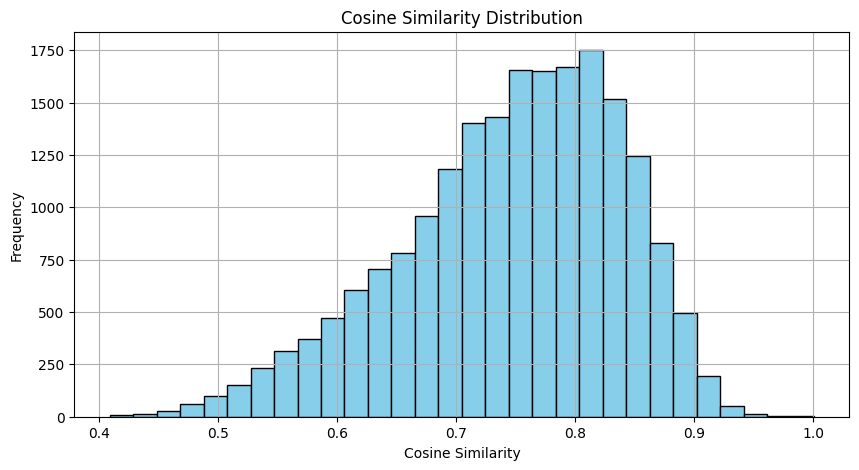

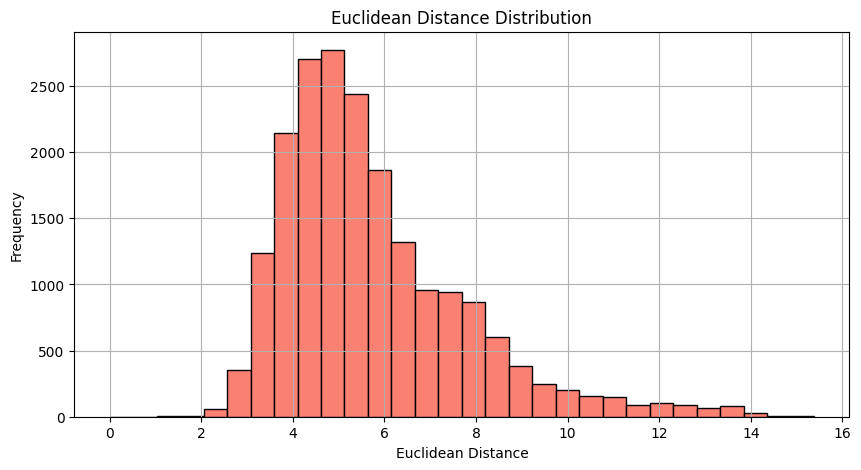

In [14]:
import matplotlib.pyplot as plt

def plot_distributions(similarity_scores):
    cosine_similarities = [score['cosine_similarity'] for score in similarity_scores]
    euclidean_distances = [score['euclidean_distance'] for score in similarity_scores]

    # Plot Cosine Similarity Distribution
    plt.figure(figsize=(10, 5))
    plt.hist(cosine_similarities, bins=30, color='skyblue', edgecolor='black')
    plt.title("Cosine Similarity Distribution")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Plot Euclidean Distance Distribution
    plt.figure(figsize=(10, 5))
    plt.hist(euclidean_distances, bins=30, color='salmon', edgecolor='black')
    plt.title("Euclidean Distance Distribution")
    plt.xlabel("Euclidean Distance")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Visualize the distributions
plot_distributions(similarity_scores)


In [15]:
def select_for_augmentation(similarity_scores, cos_threshold=0.7, euc_threshold=6.0):
    """
    Select features for augmentation based on thresholds.
    """
    to_augment = []
    for score in similarity_scores:
        if score['cosine_similarity'] < cos_threshold or score['euclidean_distance'] > euc_threshold:
            to_augment.append((score['file1'], score['file2']))
    return to_augment

to_augment_pairs = select_for_augmentation(similarity_scores)
print(f"Number of feature pairs selected for augmentation: {len(to_augment_pairs)}")


Number of feature pairs selected for augmentation: 7506


In [19]:
import os
import torch

def augment_features(files, output_dir, noise_level=0.01):
    """
    Augment features by adding Gaussian noise to individual feature files.

    Args:
        files (list): List of feature file paths to augment.
        output_dir (str): Directory to save augmented features.
        noise_level (float): Standard deviation of Gaussian noise.

    Returns:
        None
    """
    os.makedirs(output_dir, exist_ok=True)

    for file in files:
        try:
            # Load features
            data = torch.load(file)
            features = data.get("features")
            if features is None:
                print(f"File {file} does not contain 'features'. Skipping.")
                continue

            # Generate augmented features
            aug_features = features + noise_level * torch.randn_like(features)

            # Save augmented features
            base_name = os.path.basename(file).replace(".pt", "_aug.pt")
            torch.save({"features": aug_features}, os.path.join(output_dir, base_name))

        except Exception as e:
            print(f"Error processing file {file}: {e}")

    print(f"Augmented features saved to {output_dir}")

# Example Usage
normal_feature_dir = r"E:\MIL\CODE\normal_features"
if os.path.exists(normal_feature_dir):
    normal_files = [os.path.join(normal_feature_dir, f) for f in os.listdir(normal_feature_dir) if f.endswith(".pt")]
    augment_output_dir = r"E:\MIL\CODE\augmented_features"
    augment_features(normal_files, augment_output_dir)
else:
    print(f"Directory {normal_feature_dir} does not exist. Please check the path.")


C:\Users\vikra\AppData\Local\Temp\ipykernel_32540\352608877.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file)


Augmented features saved to E:\MIL\CODE\augmented_features


In [20]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm

def aggregate_features(feature_tensor, method="mean"):
    """
    Aggregates features across segments.

    Args:
        feature_tensor (torch.Tensor): Input feature tensor of shape [num_segments, feature_dim].
        method (str): Aggregation method ('mean' or 'max').

    Returns:
        torch.Tensor: Aggregated feature tensor of shape [feature_dim].
    """
    if method == "mean":
        return torch.mean(feature_tensor, dim=0)  # Mean pooling
    elif method == "max":
        return torch.max(feature_tensor, dim=0).values  # Max pooling
    else:
        raise ValueError("Unsupported aggregation method. Use 'mean' or 'max'.")

def calculate_similarity(feat1, feat2):
    """
    Calculate cosine similarity and Euclidean distance between two feature tensors.

    Args:
        feat1 (torch.Tensor): First feature tensor of shape [feature_dim].
        feat2 (torch.Tensor): Second feature tensor of shape [feature_dim].

    Returns:
        tuple: Cosine similarity and Euclidean distance.
    """
    # Cosine Similarity
    cosine_similarity = F.cosine_similarity(feat1, feat2, dim=0).item()

    # Euclidean Distance
    euclidean_distance = torch.norm(feat1 - feat2).item()

    return cosine_similarity, euclidean_distance

def compute_similarity_scores(directory, method="mean"):
    """
    Compute similarity scores for all pairs of feature files in a directory.

    Args:
        directory (str): Path to the directory containing feature files.
        method (str): Aggregation method ('mean' or 'max').

    Returns:
        list: A list of similarity scores (cosine similarity and Euclidean distance).
    """
    feature_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".pt")]
    aggregated_features = {}

    # Aggregate features for all files
    for file in tqdm(feature_files, desc="Aggregating features"):
        features = torch.load(file)["features"]
        aggregated_features[file] = aggregate_features(features, method=method)

    # Compute similarity scores
    similarity_scores = []
    for i, file1 in enumerate(tqdm(feature_files, desc="Calculating similarities")):
        for file2 in feature_files[i+1:]:
            feat1 = aggregated_features[file1]
            feat2 = aggregated_features[file2]
            cos_sim, euc_dist = calculate_similarity(feat1, feat2)
            similarity_scores.append({
                "file1": file1,
                "file2": file2,
                "cosine_similarity": cos_sim,
                "euclidean_distance": euc_dist
            })

    return similarity_scores

# Directory containing normal features
normal_feature_dir = r"E:\MIL\Code\augmented_features"

# Compute similarity scores
similarity_scores = compute_similarity_scores(normal_feature_dir, method="mean")

# calculate mean score
def calculate_mean_scores(similarity_scores):
    """
    Calculate the mean cosine similarity and Euclidean distance from similarity scores.

    Args:
        similarity_scores (list): List of dictionaries containing similarity metrics.

    Returns:
        tuple: Mean cosine similarity and mean Euclidean distance.
    """
    total_cosine_similarity = sum(score["cosine_similarity"] for score in similarity_scores)
    total_euclidean_distance = sum(score["euclidean_distance"] for score in similarity_scores)
    num_scores = len(similarity_scores)

    mean_cosine_similarity = total_cosine_similarity / num_scores
    mean_euclidean_distance = total_euclidean_distance / num_scores

    return mean_cosine_similarity, mean_euclidean_distance

# Save results to a file
mean_cosine_similarity, mean_euclidean_distance = calculate_mean_scores(similarity_scores)

# Save results to a file
# Ensure output directory is valid and writable
output_dir = os.getcwd()  # Use the current working directory
output_file = os.path.join(output_dir, "similarity_scores.txt")

try:
    with open(output_file, "w") as f:
        for score in similarity_scores:
            f.write(f"Cosine Similarity: {score['cosine_similarity']:.4f}, Euclidean Distance: {score['euclidean_distance']:.4f}\n")
    print(f"Similarity scores saved to {output_file}")
except OSError as e:
    print(f"Error saving similarity scores: {e}")

# Append mean scores to the file
with open(output_file, "a") as f:
    f.write(f"\nMean Cosine Similarity: {mean_cosine_similarity:.4f}\n")
    f.write(f"Mean Euclidean Distance: {mean_euclidean_distance:.4f}\n")

print(f"Similarity scores and mean values saved to {output_file}")


Aggregating features:   0%|          | 0/200 [00:00<?, ?it/s]C:\Users\vikra\AppData\Local\Temp\ipykernel_32540\2942537418.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Similarity scores saved to e:\MIL\Code\similarity_scores.txt
Similarity scores and mean values saved to e:\MIL\Code\similarity_scores.txt


In [21]:
mean_cosine_similarity

0.7460603922934987

In [22]:
mean_euclidean_distance

5.739580016783134

In [26]:
import torch
import os

def find_max_segments(data_dir):
    """
    Finds the maximum number of segments in the feature tensors for the given directory.

    Args:
        data_dir (str): Path to the directory containing feature files.

    Returns:
        int: Maximum number of segments.
        str: File name of the tensor with the max segments.
    """
    max_segments = 0
    max_file = None

    feature_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".pt")]

    for file in feature_files:
        features = torch.load(file)["features"]  # Load features
        num_segments = features.shape[0]  # Number of segments is the first dimension (B)
        if num_segments > max_segments:
            max_segments = num_segments
            max_file = file

    return max_segments, max_file

# Directories for splits
splits = {
    "train": {"normal": r"E:\MIL\Code\split\train\normal", "anomaly":r"E:\MIL\Code\split\train\anomalous"},
    "val": {"normal": r"E:\MIL\Code\split\val\normal", "anomaly": r"E:\MIL\Code\split\val\anomalous"},
    "test": {"normal": r"E:\MIL\Code\split\test\normal", "anomaly": r"E:\MIL\Code\split\test\anomalous"}
}

# Find maximum segments for each split
for split_name, dirs in splits.items():
    for label, dir_path in dirs.items():
        max_segments, max_file = find_max_segments(dir_path)
        print(f"Max segments in {split_name} {label}: {max_segments} (File: {max_file})")

C:\Users\vikra\AppData\Local\Temp\ipykernel_32540\1815697533.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load(file)["features"]  # Load features


Max segments in train normal: 675 (File: E:\MIL\Code\split\train\normal\Normal_Videos_924_x264_features_aug.pt)
Max segments in train anomaly: 887 (File: E:\MIL\Code\split\train\anomalous\Explosion046_x264_features.pt)
Max segments in val normal: 675 (File: E:\MIL\Code\split\val\normal\Normal_Videos_935_x264_features_aug.pt)
Max segments in val anomaly: 281 (File: E:\MIL\Code\split\val\anomalous\Burglary061_x264_features.pt)
Max segments in test normal: 242 (File: E:\MIL\Code\split\test\normal\Normal_Videos_925_x264_features_aug.pt)
Max segments in test anomaly: 271 (File: E:\MIL\Code\split\test\anomalous\Arrest030_x264_features.pt)


In [31]:
normal_files=[torch.load(r"E:\MIL\Code\normal_features\Normal_Videos_003_x264_features_aug.pt"),torch.load(r"E:\MIL\Code\normal_features\Normal_Videos_866_x264_features.pt"),torch.load(r"E:\MIL\Code\normal_features\Normal_Videos_656_x264_features.pt")]
anomaly_files=[torch.load(r"E:\MIL\Code\anomaly_features\Abuse001_x264_features.pt"),torch.load(r"E:\MIL\Code\anomaly_features\Abuse003_x264_features.pt"),torch.load(r"E:\MIL\Code\anomaly_features\Fighting041_x264_features.pt")]
for f in normal_files:
    print(f['features'].shape)
for f in anomaly_files:
    print(f['features'].shape)

torch.Size([89, 2048, 1, 1, 1])
torch.Size([38, 2048, 1, 1, 1])
torch.Size([57, 2048, 1, 1, 1])
torch.Size([86, 2048, 1, 1, 1])
torch.Size([116, 2048, 1, 1, 1])
torch.Size([198, 2048, 1, 1, 1])


C:\Users\vikra\AppData\Local\Temp\ipykernel_32540\2885363860.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  normal_files=[torch.load(r"E:\MIL\Code\normal_features\Norma

In [32]:
import torch
torch.load(r"E:\MIL\Code\normal_features\Normal_Videos124_x264_features.pt")['features'].shape

C:\Users\vikra\AppData\Local\Temp\ipykernel_32540\2194874579.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(r"E:\MIL\Code\normal_features\Normal_Videos124_x2

torch.Size([44, 2048, 1, 1, 1])

In [34]:
import os
import hashlib

# Function to compute the hash of a file
def compute_file_hash(filepath):
    hash_func = hashlib.sha256()  # Use SHA256 for robust hashing
    with open(filepath, "rb") as f:
        while chunk := f.read(8192):  # Read file in chunks
            hash_func.update(chunk)
    return hash_func.hexdigest()

# Function to get all file hashes in a directory
def get_file_hashes(directory):
    file_hashes = {}
    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file)
            file_hashes[filepath] = compute_file_hash(filepath)
    return file_hashes

# Directories to check
directories = {
    "train_normal": "split/train/normal",
    "train_anomalous": "split/train/anomalous",
    "val_normal": "split/val/normal",
    "val_anomalous": "split/val/anomalous",
    "test_normal": "split/test/normal",
    "test_anomalous": "split/test/anomalous",
}

# Collect all hashes
hashes = {name: get_file_hashes(path) for name, path in directories.items()}

# Compare hashes between directories
overlap_found = False
for dir1_name, dir1_hashes in hashes.items():
    for dir2_name, dir2_hashes in hashes.items():
        if dir1_name != dir2_name:  # Don't compare the same directory
            common_hashes = set(dir1_hashes.values()) & set(dir2_hashes.values())
            if common_hashes:
                print(f"Overlap found between {dir1_name} and {dir2_name}:")
                for hash_value in common_hashes:
                    file1 = [k for k, v in dir1_hashes.items() if v == hash_value]
                    file2 = [k for k, v in dir2_hashes.items() if v == hash_value]
                    print(f"  {file1[0]} == {file2[0]}")
                overlap_found = True

if not overlap_found:
    print("No overlapping files found.")


No overlapping files found.


In [35]:
pip install pytube

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip uninstall yt-dlp


^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install yt-dlp

In [ ]:
pip install --upgrade wheel setuptools


In [44]:
import yt_dlp

save_path = 'E:/MIL/Dataset/youtube'
link = 'https://www.youtube.com/watch?v=owO2-pjxOqs'

ydl_opts = {
    'format': 'bestvideo+bestaudio/best',
    'outtmpl': f'{save_path}/%(title)s.%(ext)s',
}

try:
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([link])
    print('Video downloaded successfully')
except Exception as e:
    print(f'Error during download: {e}')


OSError: [WinError 433] A device which does not exist was specified: 'yt_dlp_plugins'